# Example 2: Using HPC, IMC dataset

If you have a large dataset can't be handled on a regular computer, and you want to run it on HPC.

It's highly recommended that you run the computation part on HPC but visualize it on your local machine.

No specifc setting required to run on HPC since v0.3.0

## Data description

The sample data I used is from this article:

[A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry](https://www.sciencedirect.com/science/article/pii/S1550413118306910#sec2)

**Download the data** for following analysis: [Link](https://uofmacau-my.sharepoint.com/:u:/g/personal/yb97643_umac_mo/EXJFp1Nn_k5NphOp986lGvABmDNC_fNPGjrw5xN4NUPnRA?download=1)

For the origin data:
[Link](https://data.mendeley.com/datasets/cydmwsfztj/2) to supplement materials

The following example runs on an iMac 8-cores/40G RAM.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import anndata as ad
import spatialtis as st
from spatialtis import CONFIG

data = ad.read_h5ad("data/imc_data.h5ad")
data

AnnData object with n_obs × n_vars = 1776974 × 38
    obs: 'area', 'eccentricity', 'islet_id', 'centroid', 'image', 'case', 'slide', 'part', 'group', 'stage', 'cell_cat', 'cell_type'
    var: 'markers'

In [3]:
# set to None if run on cluster
CONFIG.WORKING_ENV = "jupyter_notebook"
# how the experiment design, the last element is the ROI
# if not use CONFIG.ROI_KEY to set which level is ROI
CONFIG.EXP_OBS = ["stage", "case", "part", "image"] 

# the key in anndata.obs that store the cell type info
CONFIG.CELL_TYPE_KEY = "cell_type" 
CONFIG.MARKER_KEY = "markers"

# turn on paralle processing
CONFIG.MULTI_PROCESSING = True

In [4]:
# basic statistic
st.cell_components(data)
st.cell_co_occurrence(data)
st.cell_density(data, ratio=0.001)
st.cell_morphology(data, metric_key='area')

Running cell components
Added to AnnData, uns: 'cell_components'
Finished! Used 446ms
Running cell co-occurrence
Added to AnnData, uns: 'cell_co_occurrence'
Finished! Used 1s784ms
Running cell density
Added to AnnData, uns: 'cell_density'
Finished! Used 18s822ms
Running cell morphology
Added to AnnData, uns: 'cell_morphology'
Finished! Used 4s653ms


In [5]:
# some spatial analysis
st.spatial_distribution(data)
st.spatial_heterogeneity(data)
st.hotspot(data, selected_types=['alpha', 'beta', 'delta', 'gamma'], search_level=2, grid_size=20)

Running spatial distribution
Method: Nearest neighbors search
Finding distribution pattern: 100%|██████████| 10335/10335 [00:07<00:00, 1340.74task/s]
Added to AnnData, uns: 'spatial_distribution'
Finished! Used 30s316ms
Running spatial heterogeneity
Method: Leibovici entropy
Calculating heterogeneity: 100%|██████████| 845/845 [00:03<00:00, 221.81ROI/s] 
Added to AnnData, uns: 'spatial_heterogeneity'
Finished! Used 43s368ms
Running hotspot detection
Hotspot analysis: 100%|██████████| 2290/2290 [00:01<00:00, 2039.28task/s]
Added to AnnData, uns: 'hotspot'
Finished! Used 9s783ms


In [6]:
# other spatial analysis rely on neighborhood data
n = st.Neighbors(data, "point")
n.find_neighbors(expand=8)
st.neighborhood_analysis(n, resample=999, order=False)

Finding cell neighbors
Cell resolved as point data, searching neighbors using KD-tree
Find neighbors: 100%|██████████| 845/845 [00:13<00:00, 61.21ROI/s]
Finished! Used 15s738ms
Running neighborhood analysis
Neighborhood analysis: 100%|██████████| 845/845 [06:44<00:00,  2.09ROI/s]
Added to AnnData, uns: 'neighborhood_analysis'
Finished! Used 6m44s


To reduce process time, it's suggested that you select only interested markers for analysis.

In [7]:
selected_markers=["INS","CD38","CD44","PCSK2","CD99","CD68","MPO","SLC2A1",
"CD20","AMY2A","CD3e","PPY","PIN","GCG","PDX1","SST","SYP","KRT19",
"CD45","FOXP3","CD45RA","CD8a","IAPP","NKX6-1","CD4","PTPRN","cCASP3"]

st.spatial_enrichment_analysis(n, selected_markers=selected_markers, threshold=2, resample=500)

Running spatial enrichment analysis
Spatial enrichment analysis: 100%|██████████| 845/845 [35:02<00:00,  2.49s/ROI]    
Added to AnnData, uns: 'spatial_enrichment_analysis'
Finished! Used 35m7s


In [8]:
st.communities(n)

Running community detection
Communities detection: 100%|██████████| 845/845 [00:08<00:00, 97.24ROI/s] 
Finished! Used 38s714ms


In [9]:
pancreatic_cells = ["alpha", "delta", "beta", "gamma", "acinar", "ductal"]
pancreatic_markers = ["INS", "PIN", "GCG", "SST", "PPY", "NKX6-1", "PDX1", "IAPP", "PCSK2", "SYP", 
                      "CD99", "SLC2A1", "PTPRN", "AMY2A", "KRT19", "CD44"]
cdata = data[data.obs['cell_type'].isin(pancreatic_cells)].copy().T
cdata = cdata[cdata.obs['markers'].isin(pancreatic_markers)].copy().T

n_cdata = st.Neighbors(cdata, "point")
n_cdata.find_neighbors(expand=8)
st.exp_neighcells(n_cdata, std=2)
st.exp_neighexp(n_cdata)

Finding cell neighbors
Cell resolved as point data, searching neighbors using KD-tree
Find neighbors: 100%|██████████| 845/845 [00:11<00:00, 70.66ROI/s] 
Finished! Used 13s770ms
Finding marker expression influenced by neighbor cells
Fitting model: 100%|██████████| 41/41 [05:17<00:00,  7.75s/regressor]
Added to AnnData, uns: 'exp_neighcell'
Finished! Used 5m37s
Finding marker expression influenced by neighbor markers
Fitting model: 100%|██████████| 4/4 [00:05<00:00,  1.44s/regressor]
Added to AnnData, uns: 'exp_neighexp'
Finished! Used 9s875ms


In [10]:
data.write("data/imc_data_result.h5ad")

... storing 'hotspot' as categorical


In [11]:
import spatialtis.plotting as sp

Let's check the imc data.

In [12]:
data

AnnData object with n_obs × n_vars = 1776974 × 38
    obs: 'area', 'eccentricity', 'islet_id', 'centroid', 'image', 'case', 'slide', 'part', 'group', 'stage', 'cell_cat', 'cell_type', 'hotspot', 'communities'
    var: 'markers'
    uns: 'cell_components', 'cell_co_occurrence', 'cell_density', 'cell_morphology', 'spatial_distribution', 'spatial_heterogeneity', 'neighborhood_analysis', 'spatial_enrichment_analysis'
    layers: 'markers_sign'

Set the working environment to jupyter notebook

In [13]:
CONFIG

Current configurations of SpatialTis:

======CONFIGURATIONS======
EXP_OBS: ['stage', 'case', 'part', 'image']
OS: Darwin
MULTI_PROCESSING: True
WORKING_ENV: jupyter_notebook
VERBOSE.PBAR: True
VERBOSE.ANNDATA: True
VERBOSE.INFO: True

======KEYS======
CELL_TYPE_KEY: cell_type
CENTROID_KEY: centroid
AREA_KEY: area
SHAPE_KEY: cell_shape
ECCENTRICITY_KEY: eccentricity
MARKER_KEY: markers

## Data Statistic

In [14]:
islets_cells = ['gamma', 'delta', 'alpha', 'beta',][::-1]
colors = ["#7aafde","#1b65b0","#fc7f71","#db060b"][::-1]
sp.cell_components(data, 
                   ["stage", "case"], 
                   selected_types=islets_cells,
                   group_order={'stage':['Non-diabetic', 'Onset', 'Long-duration'],
                               'case':[6126,6134,6386,6278,6362,6414,6228,6380,6418,6180,6089,6264]},
                   palette=colors, 
                   title="Cell components of Islet cells",
                  yaxis_title="% of cell type")

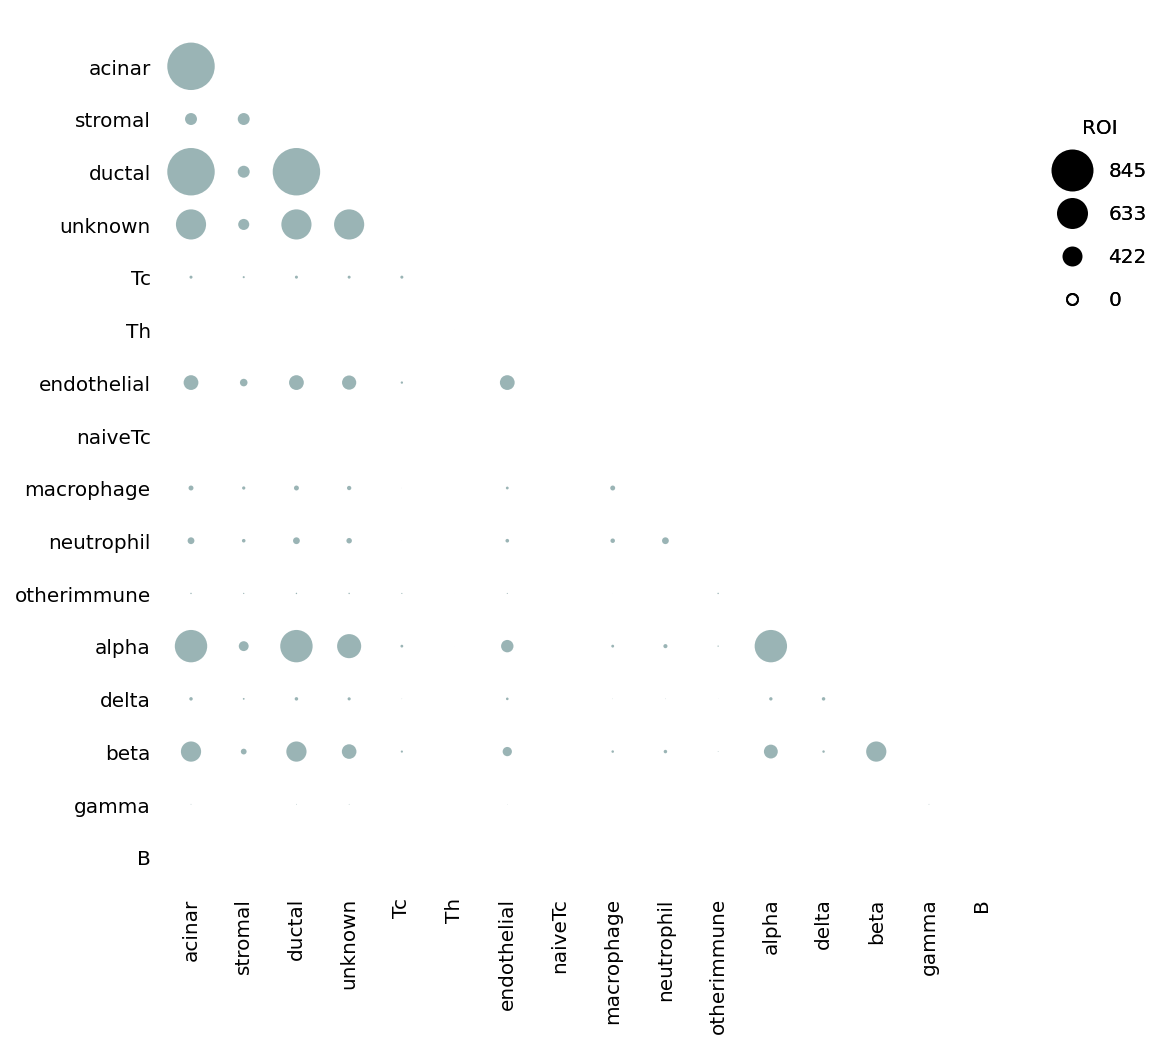

In [15]:
sp.cell_co_occurrence(data)

In [16]:
sp.cell_density(data,
                ['stage', 'type'],
                title="Cell density",
                yaxis_title="Number of cells/mm^2",
                selected_types=['alpha','beta', 'delta', 'gamma', 'Tc','naiveTc','Th','B','macrophage','neutrophil'],
                group_order={'stage':['Non-diabetic', 'Onset', 'Long-duration'],},
                size=(300, 800))

In [17]:
sp.cell_morphology(data, 
                   ['stage', 'type'], 
                   title="Cell size",
                   yaxis_title="Size of cells",
                   selected_types=['alpha','beta', 'delta', 'gamma', 'Tc','naiveTc','Th','B','macrophage','neutrophil'],
                   group_order={'stage':['Non-diabetic', 'Onset', 'Long-duration'],},
                   size=(300, 800)
                  )

## Spatial analysis

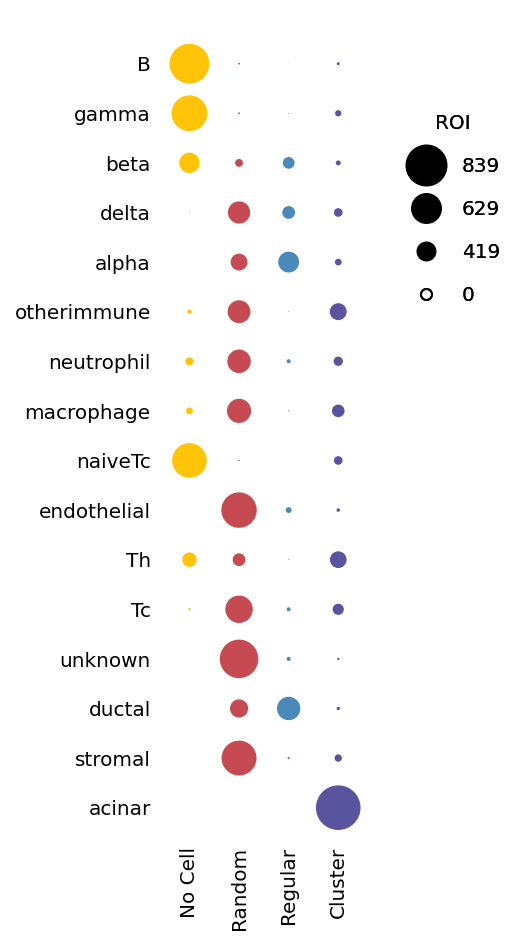

In [18]:
sp.spatial_distribution(data)

In [19]:
sp.spatial_heterogeneity(data, 
                         ['stage'], 
                         group_order={'stage':['Non-diabetic', 'Onset', 'Long-duration'],}, 
                         # title="Spatial heterogeneity of diabetes stages",
                         yaxis_title="Heterogeneity",
                         size=(300, 200))

In [20]:
sp.cell_map(data, {'stage':'Onset', 'case':6414, 'part':'Tail', 'image':'G01'}, type_key="hotspot", geom="point", size=(400, 800))
sp.cell_map(data, {'stage':'Onset', 'case':6414, 'part':'Tail', 'image':'G02'}, type_key="hotspot", geom="point", size=(400, 800))

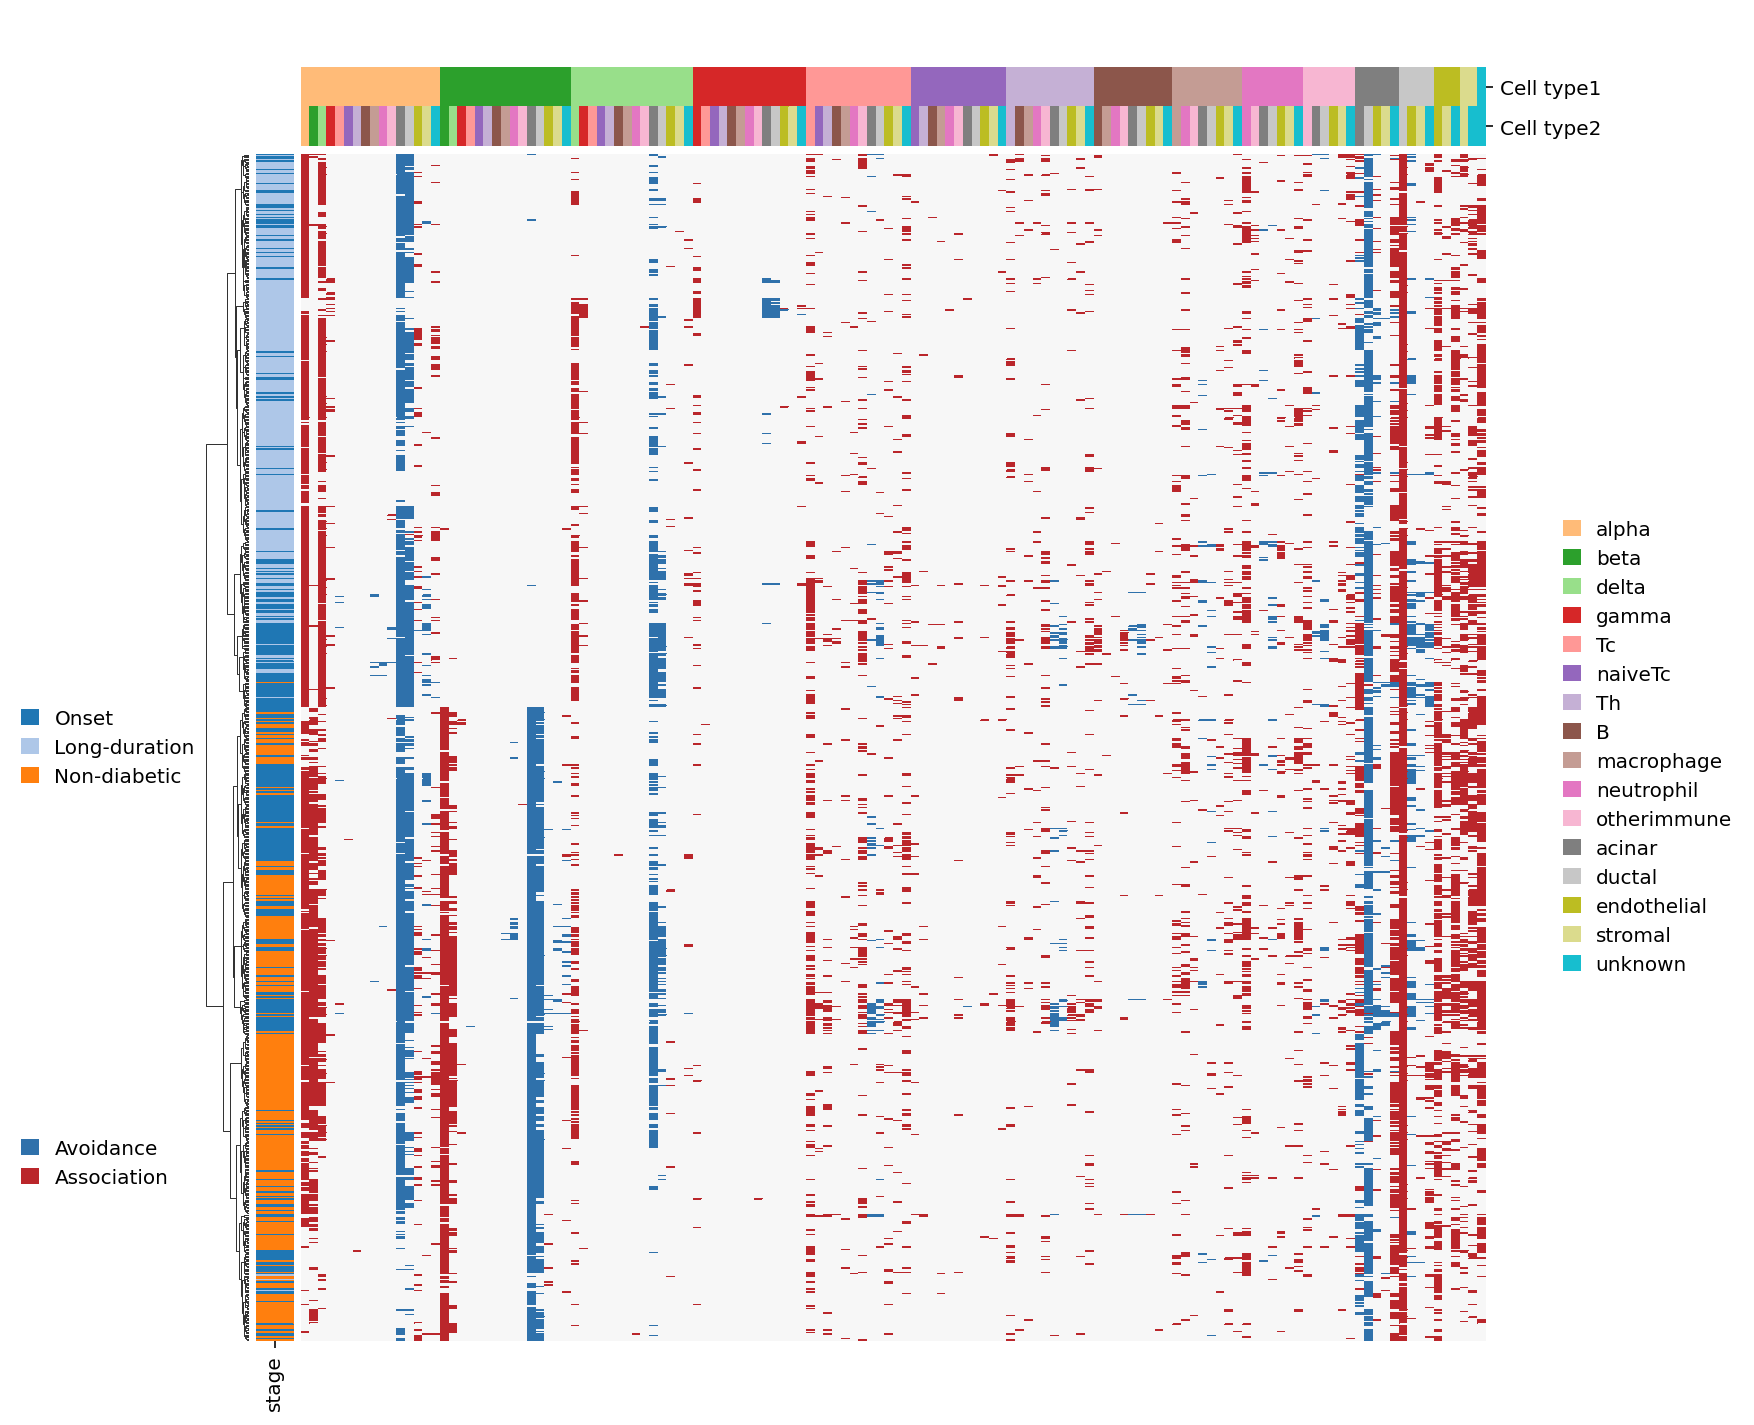

In [21]:
cell_type_order = ['alpha', 'beta', 'delta', 'gamma', 'Tc', 'naiveTc', 'Th', 'B', 'macrophage', 'neutrophil',
                  'otherimmune', 'acinar', 'ductal', 'endothelial', 'stromal', 'unknown']

sns_heatmap_args = dict(row_cluster=True, col_cluster=False, method="ward")

sp.neighborhood_analysis(data, ['stage'], selected_types=cell_type_order, use="heatmap", **sns_heatmap_args)

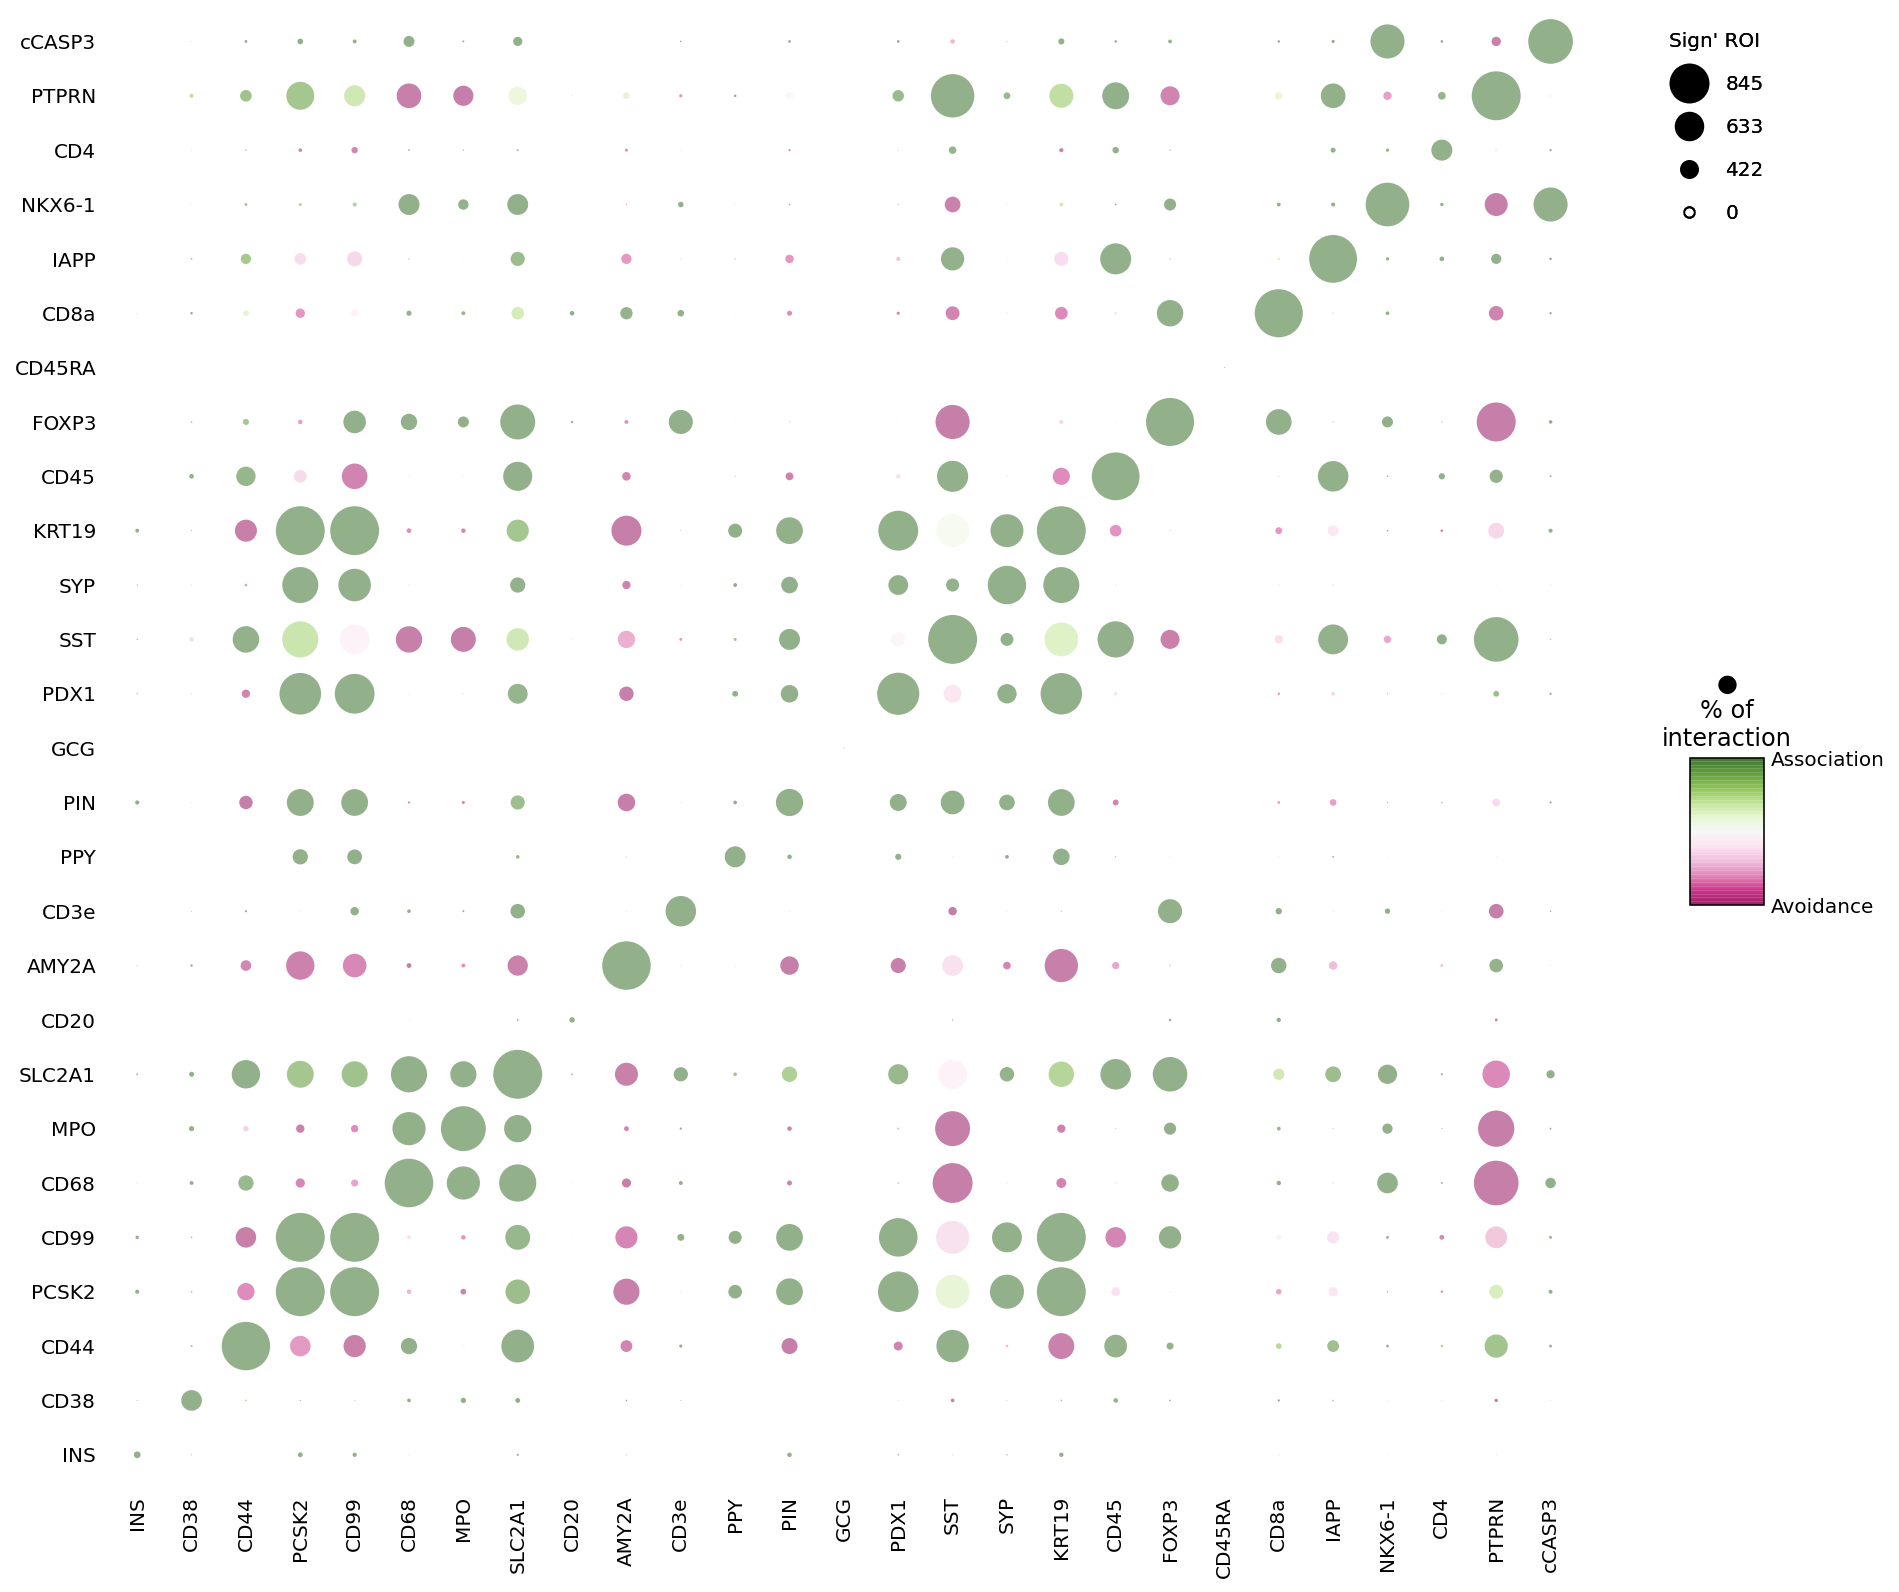

In [22]:
sp.spatial_enrichment_analysis(data)

In [23]:
sp.exp_neighcells(cdata, score=0.6, size=(300, 150))

In [24]:
from IPython.core.display import display, HTML

def row_df(dfs, captions):
    html = [df.style\
         .set_table_attributes("style='display:inline'")\
         .set_caption(caption)\
         ._repr_html_() + "\xa0\xa0\xa0" for caption, df in zip(captions, dfs)]

    display(HTML("".join(html)))

In [25]:
row_df([st.adata_uns2df(cdata, "exp_neighcell").head(5), 
        st.adata_uns2df(cdata, "exp_neighexp").head(5)], 
       ["Markers influenced by neighbors' cell", 
        "Markers influenced by neighbors' marker"])